<a href="https://colab.research.google.com/github/The-cheater/Deep_Learning_Models/blob/main/gaf_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyts matplotlib scikit-learn
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd

# STEP 2: Set the dataset path
dataset_path = '/content/drive/MyDrive/datasets'
ca_df = pd.read_csv(os.path.join(dataset_path, "CA_gait.csv"))
hsp_df = pd.read_csv(os.path.join(dataset_path, "HSP_gait.csv"))
pd_df = pd.read_csv(os.path.join(dataset_path, "PD_gait.csv"))
hc_df = pd.read_csv(os.path.join(dataset_path, "HC_gait.csv"))
ca_df['label'] = 'CA'
hsp_df['label'] = 'HSP'
pd_df['label'] = 'PD'
hc_df['label'] = 'HC'
df = pd.concat([ca_df, hsp_df, pd_df, hc_df], ignore_index=True)
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace('\n', '', regex=True)
features = [
    'R Stance (%)', 'L Stance (%)',
    'R Swing (%)', 'L Swing (%)',
    'R Double Supp. (%)', 'L Double Supp. (%)',
    'R Step Length (m)', 'L Step Length (m)',
    'R Speed (m/s)', 'L Speed (m/s)',
    'R Hip ROM (°)', 'L Hip ROM (°)',
    'R Knee ROM (°)', 'L Knee ROM (°)',
    'R Ankle ROM (°)', 'L Ankle ROM (°)',
    'Cadence (n°step/min)', 'Step Width (m)'
]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])
!pip install pyts
from pyts.image import GramianAngularField
gaf = GramianAngularField(image_size=18, method='summation') # or any integer <= 18
gaf_images = gaf.fit_transform(X_scaled)
import matplotlib.pyplot as plt
save_path = '/content/drive/MyDrive/gaf_images'
os.makedirs(save_path, exist_ok=True)
for i, img in enumerate(gaf_images):
    label = df.iloc[i]['label']
    filename = f"{label}_{i}.png"
    plt.imsave(os.path.join(save_path, filename), img, cmap='rainbow')
    print(f"✅ Saved {len(gaf_images)} GAF images to: {save_path}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.4 MB/s eta 0:00:00


In [47]:
!pip install pyts matplotlib scikit-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from sklearn.preprocessing import MinMaxScaler
import os
from google.colab import drive

# Mount Google Drive (to access the dataset)
drive.mount('/content/drive')

# STEP 1: Set the dataset path
dataset_path = '/content/drive/MyDrive/datasets'
ca_df = pd.read_csv(os.path.join(dataset_path, "CA_gait.csv"))
hsp_df = pd.read_csv(os.path.join(dataset_path, "HSP_gait.csv"))
pd_df = pd.read_csv(os.path.join(dataset_path, "PD_gait.csv"))
hc_df = pd.read_csv(os.path.join(dataset_path, "HC_gait.csv"))

# Add labels to each dataframe
ca_df['label'] = 'CA'
hsp_df['label'] = 'HSP'
pd_df['label'] = 'PD'
hc_df['label'] = 'HC'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# Concatenate all dataframes
df = pd.concat([ca_df, hsp_df, pd_df, hc_df], ignore_index=True)

# Clean column names
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace('\n', '', regex=True)

In [51]:
# Define features for analysis
features = [
    'R Stance (%)', 'L Stance (%)',
    'R Swing (%)', 'L Swing (%)',
    'R Double Supp. (%)', 'L Double Supp. (%)',
    'R Step Length (m)', 'L Step Length (m)',
    'R Speed (m/s)', 'L Speed (m/s)',
    'R Hip ROM (°)', 'L Hip ROM (°)',
    'R Knee ROM (°)', 'L Knee ROM (°)',
    'R Ankle ROM (°)', 'L Ankle ROM (°)',
    'Cadence (n°step/min)', 'Step Width (m)'
]

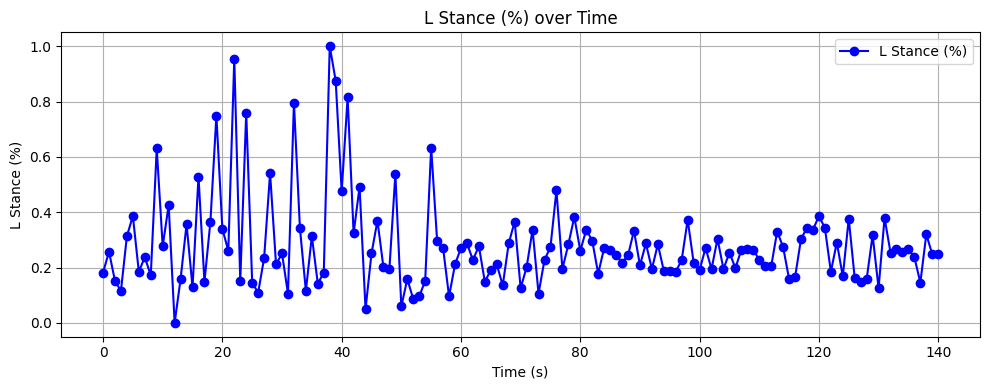

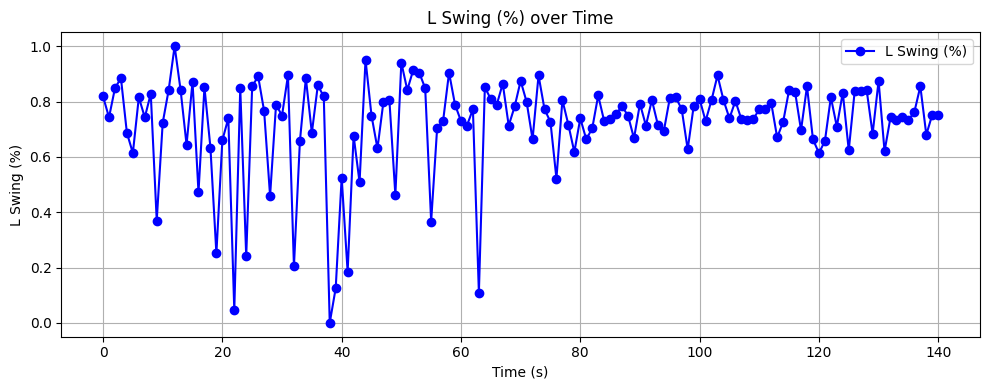

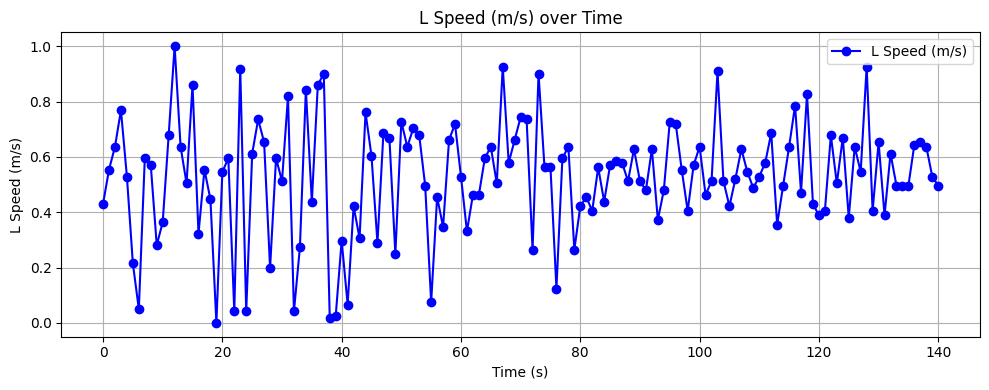

In [52]:
# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])

# Since the dataset doesn't have a 'Time' column, we'll create a synthetic time index
# Assuming each row represents a sequential measurement, we can create a time index
time = np.arange(len(X_scaled))

# STEP 2: Plot time series for selected features
# We'll plot a few features as time series, similar to the "Left Stride Interval over Time" graph
selected_features = ['L Stance (%)', 'L Swing (%)', 'L Speed (m/s)']  # You can modify this list

for feature in selected_features:
    feature_idx = features.index(feature)
    plt.figure(figsize=(10, 4))
    plt.plot(time, X_scaled[:, feature_idx], marker='o', linestyle='-', color='blue', label=feature)
    plt.xlabel("Time (s)")
    plt.ylabel(f"{feature}")
    plt.title(f"{feature} over Time")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# STEP 3: Generate and display GAF images for selected features
# We'll create RGB GAF images similar to the reference image
gaf_sum = GramianAngularField(method='summation')
gaf_diff = GramianAngularField(method='difference')

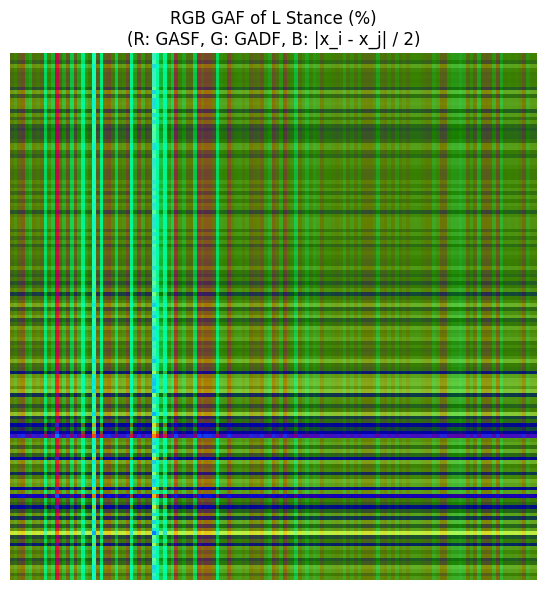

Generated RGB GAF for L Stance (%): shape=(141, 141, 3)


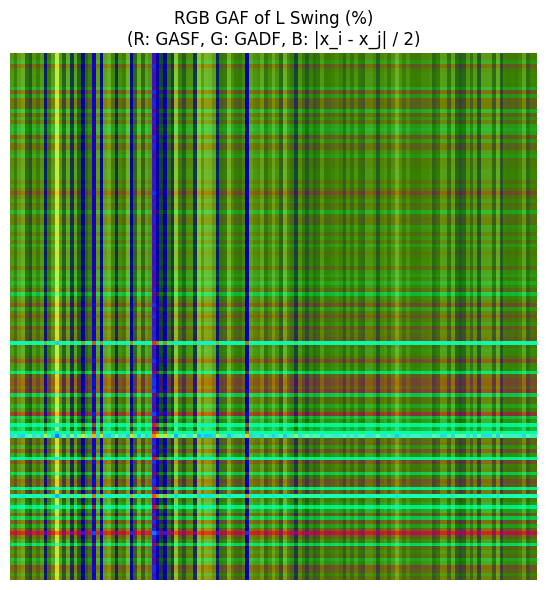

Generated RGB GAF for L Swing (%): shape=(141, 141, 3)


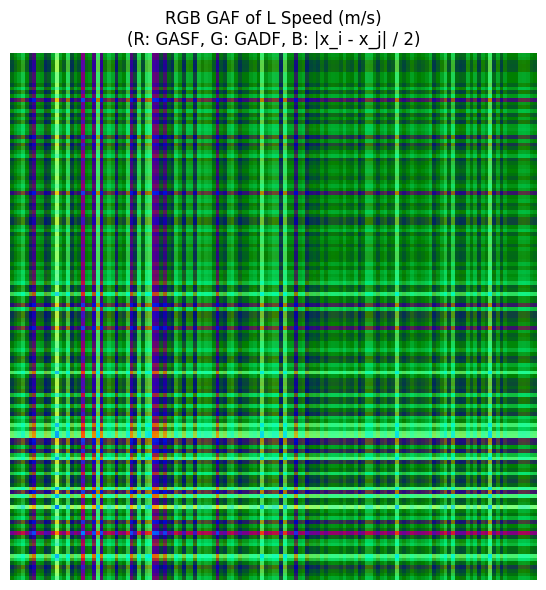

Generated RGB GAF for L Speed (m/s): shape=(141, 141, 3)


In [55]:
for feature in selected_features:
    feature_idx = features.index(feature)
    signal = X_scaled[:, feature_idx]

    # Check for valid data
    if signal.size == 0 or not np.isfinite(signal).all():
        print(f"Error: Invalid data for {feature}")
        continue

    # Normalize to [-1, 1]
    if np.max(signal) != np.min(signal):
        signal_normalized = 2 * ((signal - np.min(signal)) / (np.max(signal) - np.min(signal))) - 1
    else:
        signal_normalized = np.zeros_like(signal)
        print(f"Warning: {feature} is constant, normalized to zeros")

    # Apply GASF
    gasf_image = gaf_sum.fit_transform([signal_normalized])[0]

    # Apply GADF
    gadf_image = gaf_diff.fit_transform([signal_normalized])[0]

    # Compute meaningful blue channel: absolute difference of normalized values
    blue_channel = np.abs(signal_normalized[:, None] - signal_normalized[None, :]) / 2

    # Normalize GASF and GADF to [0, 1] for RGB
    gasf_norm = (gasf_image - gasf_image.min()) / (gasf_image.max() - gasf_image.min())
    gadf_norm = (gadf_image - gadf_image.min()) / (gadf_image.max() - gadf_image.min())

    # Create RGB image (Red: GASF, Green: GADF, Blue: absolute difference)
    rgb_image = np.zeros((gasf_image.shape[0], gasf_image.shape[1], 3))
    rgb_image[:, :, 0] = gasf_norm  # Red channel: GASF
    rgb_image[:, :, 1] = gadf_norm  # Green channel: GADF
    rgb_image[:, :, 2] = blue_channel  # Blue channel: |x_i - x_j| / 2

    # Visualize RGB GAF image
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_image, origin='lower')
    plt.title(f"RGB GAF of {feature}\n(R: GASF, G: GADF, B: |x_i - x_j| / 2)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print(f"Generated RGB GAF for {feature}: shape={rgb_image.shape}")